In [77]:
import pandas as pd
import numpy as np

data = pd.read_excel('../data/DATA_HOTEL.xlsx', header=0)
inp = data.drop(labels=["日期", "星级平均房价增长", "五星级平均房价增长"], axis=1).values
# 超参数
DATA_SCALE = 4
TIME_STEP = 4
PRED_STEP = 1
PRED_LENGTH = 12

In [78]:
from sklearn.preprocessing import MinMaxScaler

# 数据标准化
scr = MinMaxScaler()
std = scr.fit_transform(inp)
# 输入数据规范化
train_x, train_y = [], []
for i in range(TIME_STEP, std.shape[0] - PRED_STEP + 1):
    train_x.append(std[i - TIME_STEP:i])
    train_y.append(std[i])
train_x, train_y = np.array(train_x), np.array(train_y)

In [79]:
from matplotlib import pyplot as plt


def loss(information_loss):
    plt.figure(figsize=(12, 8))
    plt.plot(information_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [80]:
import tensorflow as tf
from keras import datasets, layers, optimizers, Sequential, metrics

# 构建全局网络，包含卷积层，池化层，双向LSTM层
network = Sequential([
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, activation='sigmoid'),
                         input_shape=(TIME_STEP, DATA_SCALE)),
    layers.Flatten(),
    layers.Dense(DATA_SCALE, activation='sigmoid')
])
# 查看网络结构
network.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirectio  (None, 4, 128)           35328     
 nal)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 37,380
Trainable params: 37,380
Non-trainable params: 0
_________________________________________________________________


Epoch 1/200
40/40 [==============================] - 1s 2ms/step - loss: 0.9656 - accuracy: 0.5125
Epoch 2/200
40/40 [==============================] - 0s 2ms/step - loss: 0.5894 - accuracy: 0.5125
Epoch 3/200
40/40 [==============================] - 0s 2ms/step - loss: 0.5815 - accuracy: 0.5625
Epoch 4/200
40/40 [==============================] - 0s 2ms/step - loss: 0.5839 - accuracy: 0.4750
Epoch 5/200
40/40 [==============================] - 0s 2ms/step - loss: 0.5858 - accuracy: 0.4500
Epoch 6/200
40/40 [==============================] - 0s 2ms/step - loss: 0.5756 - accuracy: 0.4375
Epoch 7/200
40/40 [==============================] - 0s 2ms/step - loss: 0.5744 - accuracy: 0.4875
Epoch 8/200
40/40 [==============================] - 0s 2ms/step - loss: 0.5709 - accuracy: 0.4625
Epoch 9/200
40/40 [==============================] - 0s 2ms/step - loss: 0.5702 - accuracy: 0.5000
Epoch 10/200
40/40 [==============================] - 0s 2ms/step - loss: 0.5670 - accuracy: 0.4750
Epoch 11/

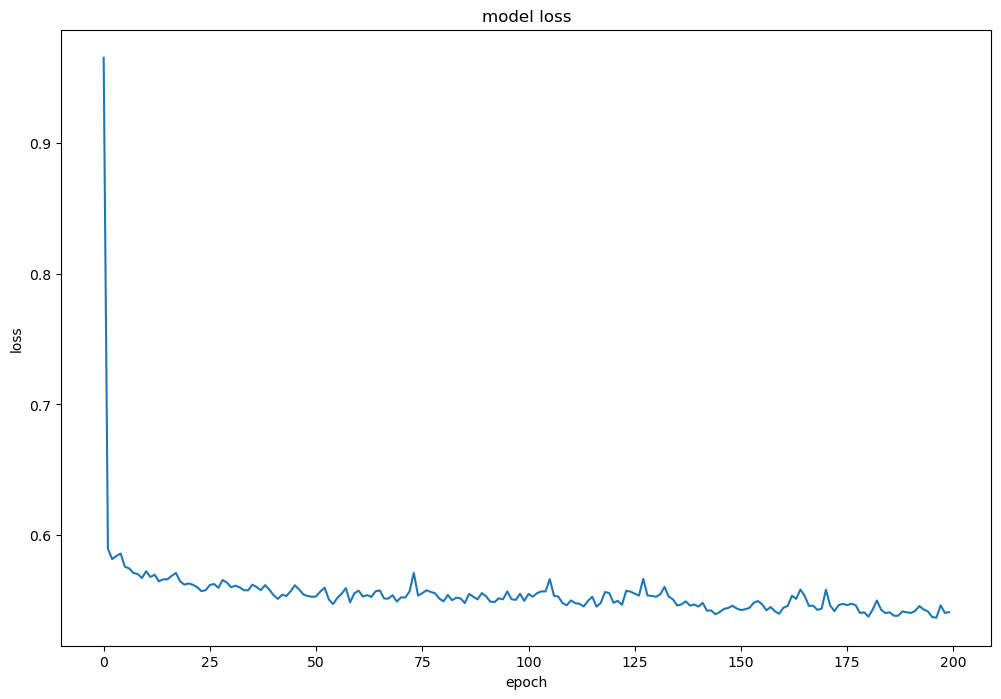

In [81]:
# 编译网络
network.compile(optimizer=optimizers.Adam(learning_rate=0.1),
                loss=tf.losses.binary_crossentropy,
                metrics=['accuracy']
                )
# 训练网络
model_information = network.fit(train_x, train_y, epochs=200, batch_size=2)
# 模型损失可视化
information_loss = model_information.history['loss']  # 模型训练损失
loss(information_loss)

In [82]:
# save and evaluate
network.save('../models/hotel_pred.h5')
flag = network.evaluate(train_x, train_y, verbose=0)
print(f'loss:{flag[0]}\nacc:{flag[1]}')

loss:0.5312759876251221
acc:0.7124999761581421


In [87]:
print(f'loss:{flag[0]}\nacc:{flag[1]}')
# 检查模型可用性
import keras

new_network = keras.models.load_model('../models/hotel_pred.h5')

loss:0.5312759876251221
acc:0.7124999761581421


In [88]:
# 单步多次预测
out = []
step = std[-TIME_STEP:]
for _ in range(PRED_LENGTH):
    tmp = new_network.predict(step.reshape(-1, TIME_STEP, DATA_SCALE))
    step = np.append(step, tmp, axis=0)
    step = np.delete(step, 0, 0)
    out.append(scr.inverse_transform(tmp).reshape(DATA_SCALE))
out = np.array(out)

1/1 [==============================] - 0s 17ms/step


In [98]:
# 将数据重塑为数据库所能接受的，并转为csv，放入数据库
from dateutil.relativedelta import relativedelta
import datetime

# 生成时间轴
START_TIME = datetime.datetime.strptime('2023-03-01', '%Y-%m-%d')
timeline = [(START_TIME + relativedelta(months=i)).strftime('%Y-%m-%d') for i in range(PRED_LENGTH)]
timeline = np.array(timeline).reshape(PRED_LENGTH, -1)

# 生成合计项
tmp = np.concatenate([timeline, out], axis=1)
res = pd.DataFrame(tmp, columns=["日期", "星级平均出租率", "星级平均房价", "五星级平均出租率", "五星级平均房价"])
res.set_index("日期")
# 合并成一个dataframe
res

,日期,星级平均出租率,星级平均房价,五星级平均出租率,五星级平均房价
0,2023-03-01,55.717926,663.4246,61.564926,819.4869
1,2023-04-01,65.00429,657.86383,67.644516,813.60864
2,2023-05-01,64.71963,644.28,66.73412,807.93475
3,2023-06-01,56.88382,649.9926,58.433743,818.0976
4,2023-07-01,52.79095,671.2268,55.026173,854.83203
5,2023-08-01,58.12443,689.6313,61.034443,878.0078
6,2023-09-01,61.78357,687.49255,64.28583,879.5734
7,2023-10-01,65.169685,693.8718,67.480446,896.51324
8,2023-11-01,66.918015,705.1637,69.366295,921.4823
9,2023-12-01,67.997475,715.6742,70.692795,940.9719


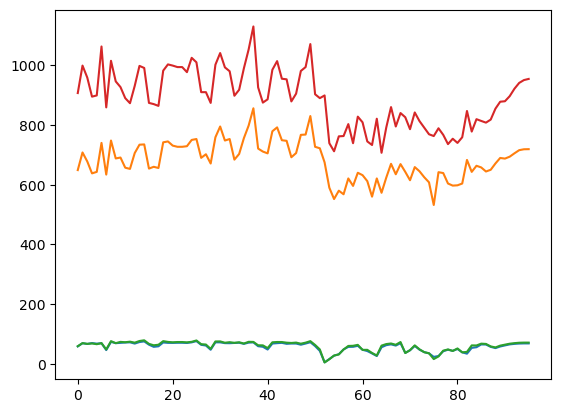

In [95]:
all = np.append(inp, out, axis=0)
length, size = all.shape
# x = [_ for _ in range(length)]
plt.plot(all)